# **Installation and Import of libraries**

In [35]:
!pip install pennylane

In [36]:
import torch
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from PIL import Image
import random


# **Data Loading and Transformations**

In [37]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts ndarray to a tensor
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [38]:
MNIST = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

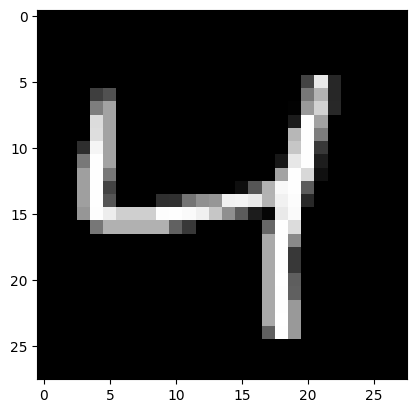

In [39]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

plt.imshow(train_dataset[2][0].squeeze(), cmap='gray')


In [40]:
# Split into features (X) and labels (y)
# X_train = torch.stack([img for img, label in train_dataset])  # Images as tensors
# y_train = torch.tensor([label for img, label in train_dataset])  # Labels as tensors

# X_test = torch.stack([img for img, label in test_dataset])  # Test images
# y_test = torch.tensor([label for img, label in test_dataset])  # Test labels

# # Print shapes
# print(f"X_train shape: {X_train.shape}")  # (60000, 1, 28, 28)
# print(f"y_train shape: {y_train.shape}")  # (60000,)

# print(f"X_test shape: {X_test.shape}")  # (10000, 1, 28, 28)
# print(f"y_test shape: {y_test.shape}")  # (10000,)

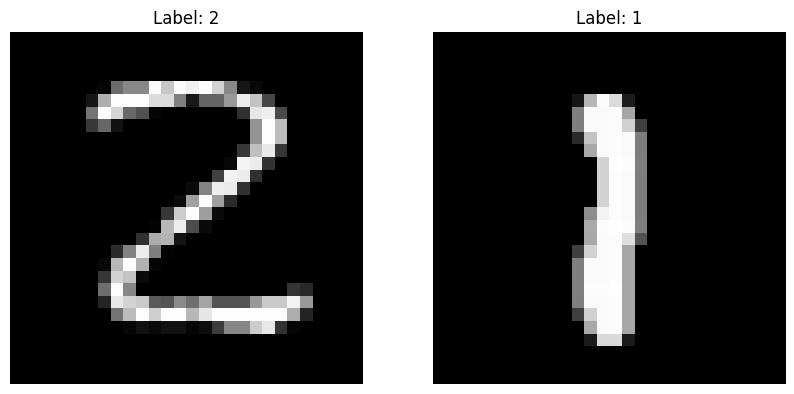

<built-in method dim of Tensor object at 0x7d3f1eb07e30>


In [41]:
import random

random_indices = random.sample(range(len(train_dataset)), 2)

# Extract the corresponding images and labels
image1, label1 = train_dataset[random_indices[0]]
image2, label2 = train_dataset[random_indices[1]]

# Plot the two selected images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image1.squeeze(), cmap='gray')
axes[0].set_title(f'Label: {label1}')
axes[0].axis('off')
axes[1].imshow(image2.squeeze(), cmap='gray')
axes[1].set_title(f'Label: {label2}')
axes[1].axis('off')

plt.show()

print(image1.dim)

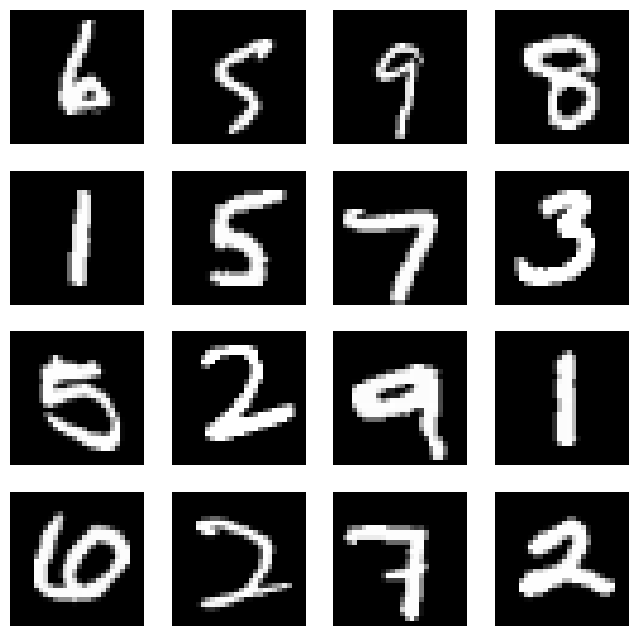

In [42]:
indices = np.random.choice(len(MNIST), 16, replace=False) #Take random images
images = []
for i in indices:
  images.append(MNIST[i][0])

fig, axes = plt.subplots(4, 4, figsize=(8, 8))

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].squeeze(), cmap='gray')
    ax.axis('off')

plt.show()

# **Preparing a quantum state for a sample image from MNIST**

In [43]:
# Function which takes two images, prepares two quantum states

dev = qml.device('default.qubit', wires = 10)
@qml.qnode(dev)
def circuit(features=None, params=None):
  qml.AmplitudeEmbedding(features=features, wires=range(10), normalize=True, pad_with=0)

  for i in range(10):
    qml.RX(params[i], wires=i)

  return qml.expval(qml.Z(0)), qml.state()

## Quantum Circuit

In [44]:
num_params = 10
sample_weights = np.random.uniform(0, 2 * np.pi, 10) #1 random rotation around X for each of the 10 qubits
print(sample_weights)

print(qml.draw(circuit)(features=image1.flatten(), params=sample_weights))

[0.10474685 3.83874417 6.17049405 1.44205668 4.91327561 4.09921739
 2.44931967 5.23739303 5.26212464 3.42456152]
0: ─╭|Ψ⟩──RX(0.10)─┤  <Z>  State
1: ─├|Ψ⟩──RX(3.84)─┤       State
2: ─├|Ψ⟩──RX(6.17)─┤       State
3: ─├|Ψ⟩──RX(1.44)─┤       State
4: ─├|Ψ⟩──RX(4.91)─┤       State
5: ─├|Ψ⟩──RX(4.10)─┤       State
6: ─├|Ψ⟩──RX(2.45)─┤       State
7: ─├|Ψ⟩──RX(5.24)─┤       State
8: ─├|Ψ⟩──RX(5.26)─┤       State
9: ─╰|Ψ⟩──RX(3.42)─┤       State


In [45]:
res1, state1 = circuit(features=image1.flatten(), params=sample_weights)
res2, state2 = circuit(features=image2.flatten(), params=sample_weights)

print(f"res1 is {res1}, res2 is {res2}")
print("\n")
print(f"state1 is {state1}, state2 is {state2}")

res1 is 0.31631474449498614, res2 is 0.30455006197400725


state1 is tensor([-0.0163+0.0077j, -0.0213+0.0121j,  0.0116-0.0186j,  ...,
        -0.0257-0.0241j, -0.0257-0.0321j, -0.0298-0.0278j],
       dtype=torch.complex128), state2 is tensor([ 0.0046-0.0181j, -0.0096-0.0054j,  0.0041-0.0225j,  ...,
        -0.0198-0.0147j, -0.0207-0.0141j, -0.0109-0.0173j],
       dtype=torch.complex128)


In [46]:
# Creating a function with similar functionalities above, and adding the SWAP test with ancillea bits
i1 = state1
i2 = state2

num_qubits = 10
dev = qml.device('default.qubit', wires= 2* num_qubits + 1)

@qml.qnode(dev)
def swap_test(i1, i2):
  inf = np.concatenate([i1,i2]) #Combine both states
  qml.AmplitudeEmbedding(inf, wires=range(1, 2*num_qubits +1), normalize=True, pad_with=0)
  qml.Hadamard(wires=0) # Step 1- Hadamard gate to ancillary bit

  for i in range(num_qubits):
    qml.CSWAP(wires=[0, i+1, i+1+num_qubits]) #Step 2- SWAP operation

  qml.Hadamard(wires=0) #Step 3- Hadamard gate to ancillary bit again

  return qml.expval(qml.PauliZ(0))


In [47]:
print(qml.draw(swap_test)(i2, i2))

 0: ──H───╭●────╭●────╭●────╭●────╭●────╭●────╭●────╭●────╭●────╭●─────H─┤  <Z>
 1: ─╭|Ψ⟩─├SWAP─│─────│─────│─────│─────│─────│─────│─────│─────│────────┤     
 2: ─├|Ψ⟩─│─────├SWAP─│─────│─────│─────│─────│─────│─────│─────│────────┤     
 3: ─├|Ψ⟩─│─────│─────├SWAP─│─────│─────│─────│─────│─────│─────│────────┤     
 4: ─├|Ψ⟩─│─────│─────│─────├SWAP─│─────│─────│─────│─────│─────│────────┤     
 5: ─├|Ψ⟩─│─────│─────│─────│─────├SWAP─│─────│─────│─────│─────│────────┤     
 6: ─├|Ψ⟩─│─────│─────│─────│─────│─────├SWAP─│─────│─────│─────│────────┤     
 7: ─├|Ψ⟩─│─────│─────│─────│─────│─────│─────├SWAP─│─────│─────│────────┤     
 8: ─├|Ψ⟩─│─────│─────│─────│─────│─────│─────│─────├SWAP─│─────│────────┤     
 9: ─├|Ψ⟩─│─────│─────│─────│─────│─────│─────│─────│─────├SWAP─│────────┤     
10: ─├|Ψ⟩─│─────│─────│─────│─────│─────│─────│─────│─────│─────├SWAP────┤     
11: ─├|Ψ⟩─╰SWAP─│─────│─────│─────│─────│─────│─────│─────│─────│────────┤     
12: ─├|Ψ⟩───────╰SWAP─│─────│─────│─────

## Quantum Embedding and Fiedlity

In [48]:
fidelity = swap_test(i1, i2)
print(fidelity)

tensor(-9.5568e-05, dtype=torch.float64)


In [49]:
qml.math.fidelity_statevector(state1, state2)


tensor(0.5402, dtype=torch.float64)

In [50]:
s1 = qml.math.dm_from_state_vector(state1)
s2 = qml.math.dm_from_state_vector(state2)
qml.math.fidelity(s1, s2)

tensor(0.5402, dtype=torch.float64)

In [51]:
# def calc_fidelity(state1, state2):
#   s1 = qml.math.dm_from_state_vector(state1)
#   s2 = qml.math.dm_from_state_vector(state2)
#   return qml.math.fidelity_statevector(s1, s2)

def calc_fidelity(state1, state2):
  return qml.math.fidelity_statevector(state1, state2)  # Directly calculate fidelity between state vectors

In [52]:
# def get_quantum_embedding(ft, w):
#   res, state = circuit(features=ft, weights=w)
#   return state

def get_quantum_embedding(ft, w):
    res, state = circuit(features=ft, params=w)  # Changed weights to params
    return state

# **Dataset Preparation, Model, Contrastive Class**

Classical Siamese Network on MNIST dataset, we will modify it to create embeddings from our previous quantum functions!

In [53]:
# Siamese Network Model

# class SiameseNetwork(nn.Module):
#     def __init__(self):
#         super(SiameseNetwork, self).__init__()

#         # CNN layers
#         self.cnn = nn.Sequential(
#             nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=2), # 1x28x28--> 64x28x28
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2), # " " " --> 128x28x28
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2)
#         )

#         # Fully connected layers
#         self.fc = nn.Sequential(
#             nn.Linear(128 * 7 * 7, 256),  # 128 channels * 7x7 feature map after CNN
#             nn.ReLU(),
#             nn.Linear(256, 128)
#         )

#     def forward(self, x):
#         # Pass through CNN layers
#         x = self.cnn(x)

#         # Flatten the output from CNN layers
#         x = x.view(x.size(0), -1)

#         # Pass through fully connected layers
#         x = self.fc(x)

#         return x


## Dataset (in pairs)

In [55]:
class SiameseDataset(Dataset):
    def __init__(self, dataset, transform= None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        # Get the image and its label from the dataset
        img1, label1 = self.dataset[index]

        # Convert to PIL Image if it's a tensor (for compatibility with torchvision transforms)
        if isinstance(img1, torch.Tensor):
            # Convert the tensor to a NumPy array and scale to 0-255
            img1 = img1.numpy() * 255
            # Convert to uint8 to make it compatible with Image.fromarray
            img1 = img1.astype(np.uint8)
            img1 = Image.fromarray(img1.squeeze()) # Squeeze to remove unnecessary channel dimension

        # Randomly decide whether to use a positive or negative pair
        same_class = random.randint(0, 1)  # 0: negative pair, 1: positive pair

        # Positive pair: Same class
        if same_class == 1:
            # Get a random index of the same class
            same_class_indices = [i for i, (_, label) in enumerate(self.dataset) if label == label1]
            img2_idx = random.choice(same_class_indices)
            img2, label2 = self.dataset[img2_idx]

            # Convert to PIL Image if it's a tensor
            if isinstance(img2, torch.Tensor):
                # Convert the tensor to a NumPy array and scale to 0-255
                img2 = img2.numpy() * 255
                # Convert to uint8 to make it compatible with Image.fromarray
                img2 = img2.astype(np.uint8)
                img2 = Image.fromarray(img2.squeeze()) # Squeeze to remove unnecessary channel dimension

            label = 1  # Same class
        else:
            # Negative pair: Different class
            different_class_indices = [i for i, (_, label) in enumerate(self.dataset) if label != label1]
            img2_idx = random.choice(different_class_indices)
            img2, label2 = self.dataset[img2_idx]

            # Convert to PIL Image if it's a tensor
            if isinstance(img2, torch.Tensor):
                # Convert the tensor to a NumPy array and scale to 0-255
                img2 = img2.numpy() * 255
                # Convert to uint8 to make it compatible with Image.fromarray
                img2 = img2.astype(np.uint8)
                img2 = Image.fromarray(img2.squeeze()) # Squeeze to remove unnecessary channel dimension

            label = 0  # Different class

        # Apply transformations if provided
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, label

    def __len__(self):
        return len(self.dataset)


In [54]:
class SiameseDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        # Get the image and its label from the dataset
        img1, label1 = self.dataset[index]

        # Randomly decide whether to use a positive or negative pair
        same_class = random.randint(0, 1)  # 0: negative pair, 1: positive pair

        # Positive pair: Same class
        if same_class == 1:
            # Get a random index of the same class
            same_class_indices = [i for i, (_, label) in enumerate(self.dataset) if label == label1]
            img2_idx = random.choice(same_class_indices)
            img2, label2 = self.dataset[img2_idx]
            label = 1  # Same class
        else:
            # Negative pair: Different class
            different_class_indices = [i for i, (_, label) in enumerate(self.dataset) if label != label1]
            img2_idx = random.choice(different_class_indices)
            img2, label2 = self.dataset[img2_idx]
            label = 0  # Different class

        # Apply transformations if provided
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, label

    def __len__(self):
        return len(self.dataset)


In [56]:
class SiameseDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

        # Precompute class indices
        self.class_indices = {}
        for i, (_, label) in enumerate(dataset):
            if label not in self.class_indices:
                self.class_indices[label] = []
            self.class_indices[label].append(i)

    def __getitem__(self, index):
        img1, label1 = self.dataset[index]

        # Select same or different class
        same_class = random.randint(0, 1)
        if same_class == 1:  # Positive Pair
            img2_idx = random.choice(self.class_indices[label1])
        else:  # Negative Pair
            label2 = random.choice(list(set(self.class_indices.keys()) - {label1}))
            img2_idx = random.choice(self.class_indices[label2])

        img2, label2 = self.dataset[img2_idx]
        label = 1 if same_class else 0

        # Apply transformations
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, torch.tensor(label, dtype=torch.float32)

    def __len__(self):
        return len(self.dataset)


## Contrastive Loss

In [57]:
# def calc_contrastive_loss(margin, y_true, embedding1, embedding2):
#   D = torch.norm(embedding1 - embedding2, dim=1) # (embedding1 - embedding2) **2
#   min_term = (1-y_true)* D**2
#   max_term = y_true * torch.max(0, margin-D)**2
#   loss = torch.mean(min_term + max_term)
#   return loss

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, y_true, embedding1, embedding2):
        D = torch.norm(embedding1 - embedding2, dim=1)  # (embedding1 - embedding2) **2
        min_term = (1 - y_true) * D**2
        max_term = y_true * torch.max(torch.tensor(0.0), self.margin - D)**2  # Use self.margin
        loss = torch.mean(min_term + max_term)
        return loss

## Siamese Model

In [ ]:
# # Model Class for Siamese Network with Quantum Embedding
# class SiameseNetwork(nn.Module):
#     def __init__(self):
#         super(SiameseNetwork, self).__init__()

#         # Quantum weights (initialized randomly for simplicity)
#         sample_weights_init = np.random.uniform(0, 2 * np.pi, (10, 2))  # Uniform distribution [0, 2π)
#         self.sample_weights = torch.nn.Parameter(torch.tensor(sample_weights_init, dtype=torch.float32))  # Convert to torch tensor

#     def forward(self, img1, img2):
#     # Flatten images
#      img1_flat = img1.reshape(img1.shape[0], -1)
#      img2_flat = img2.reshape(img2.shape[0], -1)

#     # Generate quantum embeddings for both images
#      embedding1 = get_quantum_embedding(img1_flat, self.sample_weights)
#      embedding2 = get_quantum_embedding(img2_flat, self.sample_weights)

#     # Calculate fidelity (similarity measure)
#      similarity = calc_fidelity(embedding1, embedding2)

#      return similarity

# # Training step for Contrastive Loss
# def train_step(model, x1, x2, labels, criterion, optimizer):
#     # Forward pass through the Siamese network
#     similarity = model(x1, x2)

#     # Calculate contrastive loss
#     loss = criterion(labels, similarity)

#     # Backpropagation
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#     return loss.item()

In [58]:
# Training step for Contrastive Loss

def train_step(model, x1, x2, labels, criterion, optimizer):
    # similarity = model(x1, x2)  # This line was the issue
    embedding1, embedding2 = model(x1, x2)  # Update to return embeddings

    # Calculate contrastive loss
    # loss = criterion(labels, similarity)  # Update to use embeddings
    loss = criterion(labels, embedding1, embedding2)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()


class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        sample_weights_init = np.random.uniform(0, 2 * np.pi, (10, 2))  # Uniform distribution [0, 2π)
        self.sample_weights = torch.nn.Parameter(torch.tensor(sample_weights_init, dtype=torch.float32))  # Convert to torch tensor, and parameterise for updates

    def forward(self, img1, img2):
        # Flatten images
        img1_flat = img1.reshape(img1.shape[0], -1)
        img2_flat = img2.reshape(img2.shape[0], -1)

        # Generate quantum embeddings for both images
        embedding1 = get_quantum_embedding(img1_flat, self.sample_weights) #BLUNDER, flatten images
        embedding2 = get_quantum_embedding(img2_flat, self.sample_weights)

        return embedding1, embedding2  # Return both embeddings

## Parameters

In [59]:
#Training parameters

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SiameseNetwork()
model = model.to(device)

epochs = 5
lr = 0.01
criterion = ContrastiveLoss(margin=1.0)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# siamese_train_dataset = SiameseDataset(train_dataset, transform=transform) #BLUNDER
siamese_train_dataset = SiameseDataset(train_dataset, transform=None)
train_dataloader = DataLoader(siamese_train_dataset, batch_size=128, shuffle=True)

In [60]:
siamese_test_dataset = SiameseDataset(test_dataset, transform=None)
test_dataloader = DataLoader(siamese_test_dataset, batch_size=64, shuffle=False)

## Training

In [61]:
threshold= 0.7

In [64]:
# def train_model(model, train_dataloader, criterion, optimizer, epochs=5):
#     model.train()  # Set the model to training mode
#     loss_list = []

#     for epoch in range(epochs):
#         total_loss = 0

#         # Wrap the training dataloader with tqdm for progress tracking
#         for img1, img2, labels in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch"):
#             # Convert the images (ndarrays) to torch tensors
#             img1, img2, labels = img1.float().cuda(), img2.float().cuda(), labels.long().cuda()

#             # Perform training step
#             loss = train_step(model, img1, img2, labels, criterion, optimizer)

#             total_loss += loss

#         # Record loss for the epoch
#         avg_loss = total_loss / len(train_dataloader)
#         loss_list.append(avg_loss)
#         print(f'Epoch {epoch+1}/{epochs} - Average Loss: {avg_loss:.4f}')

#     return loss_list

def train_model(model, train_dataloader, criterion, optimizer, epochs=5):
    model.train()  # Set the model to training mode
    loss_list = []

    for epoch in range(epochs):
        total_loss = 0

        for img1, img2, labels in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch"):
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            img1, img2, labels = img1.float().to(device), img2.float().to(device), labels.long().to(device)

            # Process each image in the batch individually
            batch_loss = 0
            # Accumulate loss for the batch
            for i in range(img1.shape[0]):  # Iterate over the batch size
                loss = train_step(model, img1[i].unsqueeze(0), img2[i].unsqueeze(0), labels[i].unsqueeze(0), criterion, optimizer)
                batch_loss += loss

            # Average the loss over the batch
            total_loss += batch_loss / img1.shape[0]

        # Record loss for the epoch
        avg_loss = total_loss / len(train_dataloader)
        loss_list.append(avg_loss)
        print(f'Epoch {epoch+1}/{epochs} - Average Loss: {avg_loss:.4f}')

    return loss_list

In [66]:
# Start the training process

loss_list = train_model(model, train_dataloader, criterion, optimizer, epochs=5)

Epoch 1/5: 100%|██████████| 469/469 [33:08<00:00,  4.24s/batch]


Epoch 1/5 - Average Loss: 0.3620


Epoch 2/5: 100%|██████████| 469/469 [33:38<00:00,  4.30s/batch]


Epoch 2/5 - Average Loss: 0.3622


Epoch 3/5: 100%|██████████| 469/469 [32:56<00:00,  4.21s/batch]


Epoch 3/5 - Average Loss: 0.3624


Epoch 4/5: 100%|██████████| 469/469 [32:49<00:00,  4.20s/batch]


Epoch 4/5 - Average Loss: 0.3647


Epoch 5/5: 100%|██████████| 469/469 [33:09<00:00,  4.24s/batch]

Epoch 5/5 - Average Loss: 0.3624


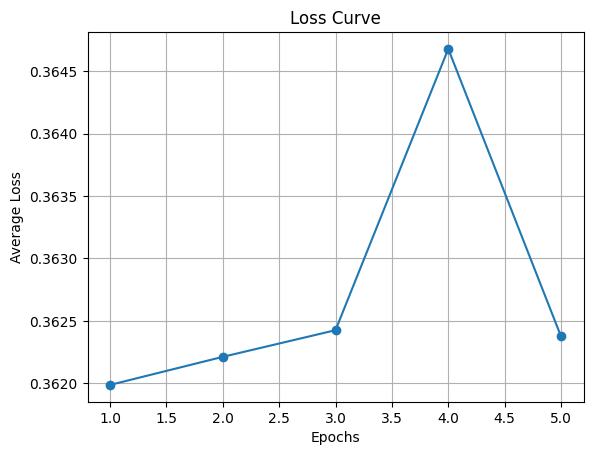

In [69]:
def plot_loss_curve(loss_list):
    epochs = range(1, len(loss_list) + 1)
    plt.plot(epochs, loss_list, marker='o')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Average Loss')
    plt.grid(True)
    plt.show()

plot_loss_curve(loss_list)

In [ ]:
# def evaluate_model(model, eval_dataloader, criterion):
#     model.eval()  # Set the model to evaluation mode
#     total_loss = 0
#     fidelities = []
#     pair_types = []  # 'same class' or 'different class'

#     with torch.no_grad():  # Disable gradient computation for evaluation
#         for img1, img2, labels in tqdm(eval_dataloader, desc="Evaluating", unit="batch"):
#             img1, img2, labels = img1.float().cuda(), img2.float().cuda(), labels.long().cuda()

#             batch_loss = 0
#             for i in range(img1.shape[0]):
#                 # Calculate loss for each image pair
#                 loss = train_step(model, img1[i].unsqueeze(0), img2[i].unsqueeze(0), labels[i].unsqueeze(0), criterion, None)
#                 batch_loss += loss

#                 # Calculate fidelity (simulated for demonstration purposes)
#                 fidelity = torch.exp(-loss).item()  # Example: fidelity derived from loss
#                 fidelities.append(fidelity)

#                 # Determine pair type based on labels
#                 pair_types.append('same class' if labels[i].item() == 1 else 'different class')

#             # Average loss per batch
#             total_loss += batch_loss / img1.shape[0]

#     avg_loss = total_loss / len(eval_dataloader)
#     print(f'Evaluation - Average Loss: {avg_loss:.4f}')
#     return avg_loss, fidelities, pair_types

# def evaluate_model(model, eval_dataloader, criterion):
#     model.eval()  # Set the model to evaluation mode
#     total_loss = 0
#     fidelities = []
#     pair_types = []  # 'same class' or 'different class'

#     with torch.no_grad():  # Disable gradient computation for evaluation
#         for img1, img2, labels in tqdm(eval_dataloader, desc="Evaluating", unit="batch"):
#             img1, img2, labels = img1.float().cuda(), img2.float().cuda(), labels.long().cuda()

#             batch_loss = 0
#             for i in range(img1.shape[0]):
#                 # Calculate loss for each image pair
#                 # Removed optimizer from train_step call as it's not needed for evaluation
#                 # and was causing the AttributeError
#                 embedding1, embedding2 = model(img1[i].unsqueeze(0), img2[i].unsqueeze(0))
#                 loss = criterion(labels[i].unsqueeze(0), embedding1, embedding2)
#                 batch_loss += loss

#                 # Calculate fidelity (simulated for demonstration purposes)
#                 fidelity = torch.exp(-loss).item()  # Example: fidelity derived from loss
#                 fidelities.append(fidelity)

#                 # Determine pair type based on labels
#                 pair_types.append('same class' if labels[i].item() == 1 else 'different class')

#             # Average loss per batch
#             total_loss += batch_loss / img1.shape[0]

#     avg_loss = total_loss / len(eval_dataloader)
#     print(f'Evaluation - Average Loss: {avg_loss:.4f}')
#     return avg_loss, fidelities, pair_types

In [68]:
class_names = [str(i) for i in range(10)]  # Class names are simply digits

print("Class names:", class_names)

Class names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [77]:
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc

def evaluate_and_plot_metrics(model, eval_dataloader, criterion, class_names):
    model.eval()
    total_loss = 0
    fidelities = []
    pair_types = []
    y_true = []
    y_pred = []
    y_scores = []

    with torch.no_grad():
        for img1, img2, labels in tqdm(eval_dataloader, desc="Evaluating", unit="batch"):
            device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
            img1, img2, labels = img1.float().to(device), img2.float().to(device), labels.long().to(device)

            batch_loss = 0
            for i in range(img1.shape[0]):
                # Get embeddings from the model
                embedding1, embedding2 = model(img1[i].unsqueeze(0), img2[i].unsqueeze(0))

                # Calculate the loss using the criterion
                loss = criterion(labels[i].unsqueeze(0), embedding1, embedding2)

                batch_loss += loss

                # Calculate fidelity
                fidelity = torch.exp(-loss).item()  # Example: fidelity derived from loss
                fidelities.append(fidelity)
                y_scores.append(fidelity)

                # Determine pair type based on labels
                pair_types.append('same class' if labels[i].item() == 1 else 'different class')

                # Collect true labels and predicted labels
                y_true.append(labels[i].item())
                y_pred.append(1 if fidelity > 0.5 else 0)  # Modify threshold as needed

            # Average loss per batch
            total_loss += batch_loss / img1.shape[0]

    avg_loss = total_loss / len(eval_dataloader)
    print(f'Evaluation - Average Loss: {avg_loss:.4f}')

    # Compute Precision, Recall, and F1-Score
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')  # Binary classification assumed
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-Score: {f1:.4f}')

    fig, axes = plt.subplots(1, 3, figsize=(24, 6))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    unique_labels = sorted(list(set(y_true + y_pred)))
    num_classes = len(unique_labels)

    class_names = [str(label) for label in unique_labels]

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=axes[0], cmap=plt.cm.Blues)
    axes[0].set_title("Class-wise Confusion Matrix")

    # Fidelity vs Pair Type
    data = {"Fidelity": fidelities, "Pair Type": pair_types}
    sns.boxplot(x="Pair Type", y="Fidelity", data=data, palette="Set2", ax=axes[1])
    sns.stripplot(x="Pair Type", y="Fidelity", data=data, jitter=True, color=".3", alpha=0.5, ax=axes[1])
    axes[1].set_title("Fidelity vs Pair Type")
    axes[1].set_xlabel("Pair Type")
    axes[1].set_ylabel("Fidelity")
    axes[1].grid(axis='y', linestyle='--', alpha=0.7)

    # ROC-AUC Curve
    fpr, tpr, _ = roc_curve(y_true, y_scores, pos_label=1)  # Assuming positive label is 1
    roc_auc = auc(fpr, tpr)
    axes[2].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    axes[2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
    axes[2].set_title("ROC-AUC Curve")
    axes[2].set_xlabel("False Positive Rate")
    axes[2].set_ylabel("True Positive Rate")
    axes[2].legend(loc="lower right")
    axes[2].grid()

    plt.tight_layout()
    plt.show()

    return avg_loss, fidelities, pair_types


Evaluating: 100%|██████████| 157/157 [04:24<00:00,  1.68s/batch]
<ipython-input-77-7a31207b1401>:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Pair Type", y="Fidelity", data=data, palette="Set2", ax=axes[1])


Evaluation - Average Loss: 0.3688
Precision: 0.5708
Recall: 0.9988
F1-Score: 0.7264


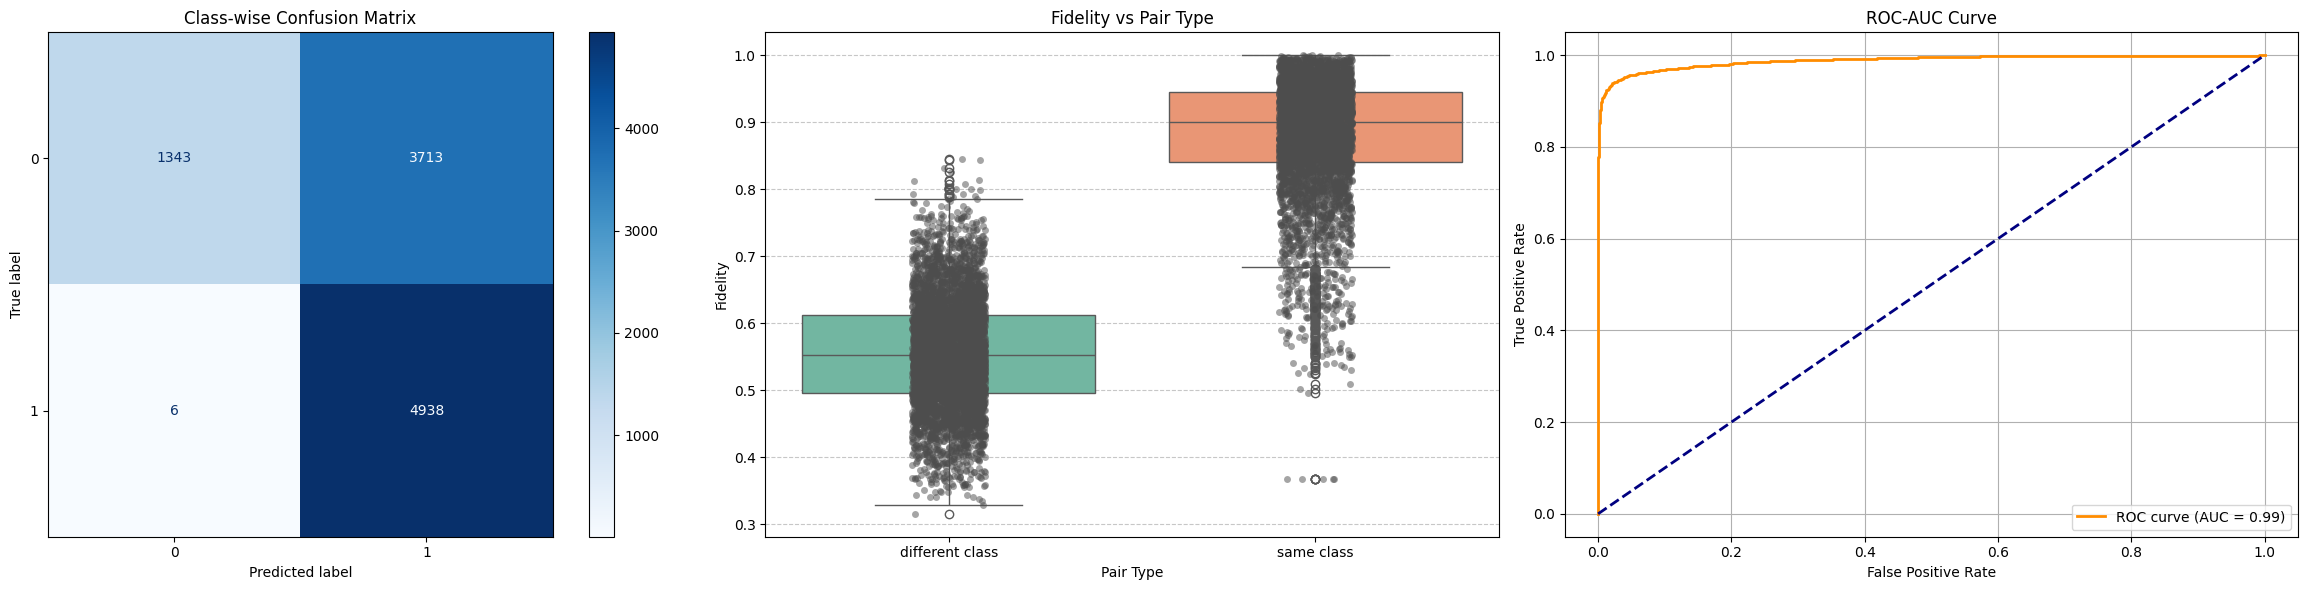

(tensor(0.3688),
 [0.6167662143707275,
  0.46161213517189026,
  0.6213359832763672,
  0.5001491904258728,
  0.7993393540382385,
  0.6718935966491699,
  0.863508939743042,
  0.8638597726821899,
  0.891131579875946,
  0.47870877385139465,
  0.5639660954475403,
  0.5393463373184204,
  0.823914110660553,
  0.823576807975769,
  0.6437981724739075,
  0.5447537899017334,
  0.9318804144859314,
  0.6999076008796692,
  0.9349093437194824,
  0.8344343900680542,
  0.8569682836532593,
  0.8152530193328857,
  0.5765663981437683,
  0.8709997534751892,
  0.8572168350219727,
  0.39167657494544983,
  0.8116233348846436,
  0.6890385150909424,
  0.5609337687492371,
  0.525669515132904,
  0.9245483875274658,
  0.6653746962547302,
  0.6411218047142029,
  0.9360684752464294,
  0.715600311756134,
  0.9486200213432312,
  0.6055905222892761,
  0.7883785367012024,
  0.5640833973884583,
  0.7565417289733887,
  0.7795947790145874,
  0.8709287047386169,
  0.5182890892028809,
  0.9835551977157593,
  0.64935874938964

In [78]:
evaluate_and_plot_metrics(model, test_dataloader, criterion, class_names)

# **Observations**

### 1. The high number of False Positives (3713) suggests that the model tends to predict class 1 more often, potentially leading to a high recall but lower precision for class 1.

### 2. For differnt-class pairs, median fidelity score is around 0.55, and for same-class pairs it is around 0.90. Some overlap might suggest misclassifications.

### 3. AUC = 0.99 is an excellent measure.

#**Future Scope for Improvement**

### 1. We observe that the loss function does not decrease below 0.36. Trying different methods, such as implementing an LR scheduler or adjusting the margin hyperparameter in the Contrastive Loss class, may help improve it.

### 2. Visualizing the embeddings in t-SNE space.

### 3. Applying methods like PCA to reduce computational cost by preprocessing data to identify the most relevant pixels, rather than using all 784 pixels for computation.